In [386]:
import numpy as np
#np.seterr(all='raise')

import pint
si = pint.UnitRegistry()

In [387]:
from matplotlib import pyplot
%matplotlib notebook 
si.setup_matplotlib()

In [388]:
%run mpdata.ipynb

In [389]:
%run coord.ipynb

In [390]:
%run phys.ipynb
ph = phys(si)

In [391]:
class plotter:
    def __init__(self, r_min, r_max):
        self.cdfarg, self.dcdfarg = np.linspace(
            r_min.magnitude, 
            r_max.magnitude, 
            512, retstep=True
        ) * r_min.units
        
        pyplot.figure(figsize=(8,6))
        #pyplot.yscale('log')

    def done(self, title):
        pyplot.title(title)
        pyplot.grid()
        pyplot.legend()
        pyplot.show()

    def pdf_cdf(self, cdf):
        x = self.cdfarg[0:-1] + (self.cdfarg[1:] - self.cdfarg[0:-1])/2
        y = np.diff(ph.mgn(cdf(self.cdfarg))) / ph.mgn(self.dcdfarg)
        pyplot.plot(x, y)

    def pdf_pdf(self, pdf):
        x = self.cdfarg
        y = pdf(x) 
        pyplot.plot(x, ph.mgn(y), color='black')
        
    def step(self, r, pdf, t):
        pyplot.step(r, pdf, linestyle='-', where='mid', label=str(t))

In [405]:
nr = 128
nt = 256
dt = 1 * si.second
r_min = 25 * si.micrometre
r_max = 75 * si.micrometre
r_mid = r_min + .45*(r_max - r_min)

# Witch of Agnesi
A = 1e-6 
B = 2*si.micrometre
cdf0 = lambda r: A * np.arctan((r-r_mid)/B) 
pdf0 = lambda r: A/B / (((r-r_mid)/B)**2 + 1)

# Rogers and Yau p. 104
ksi_1 = 68.2 * si.micrometre**2 / si.second
S = 1.05
ksi = (S-1) * ksi_1
drdt = lambda r: ksi/r

In [406]:
def Rogers(r):
    with np.errstate(invalid='ignore'):
        arg = np.sqrt(r**2 - 2*ksi*nt*dt)
    return r / arg * pdf0(arg)

<IPython.core.display.Javascript object>


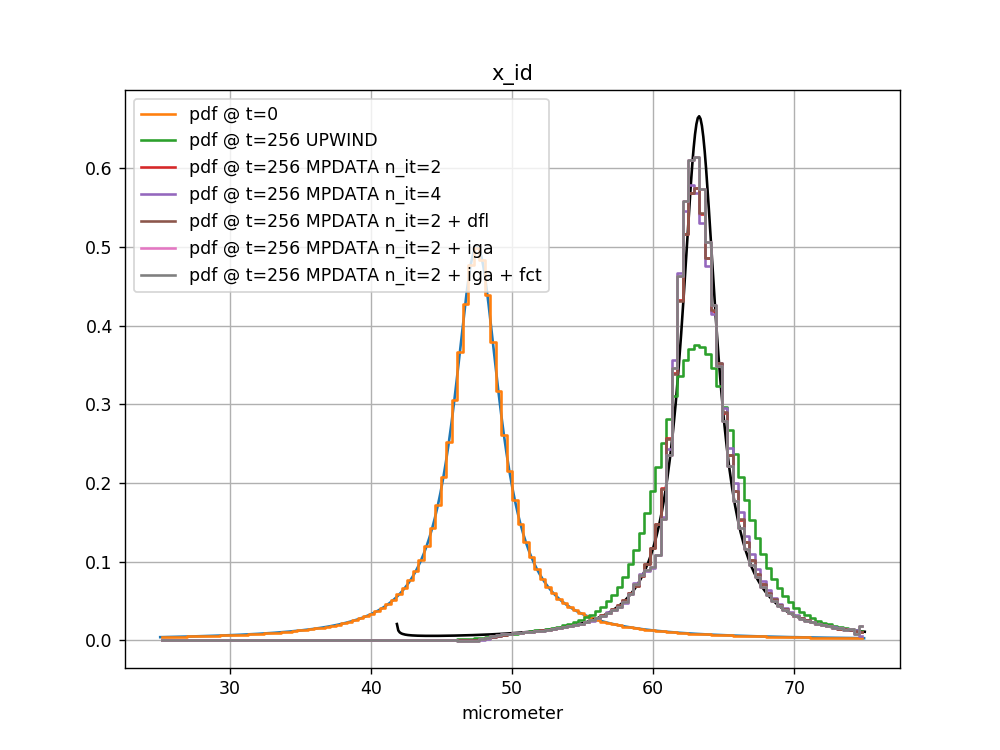

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in minimum
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in maximum


<IPython.core.display.Javascript object>


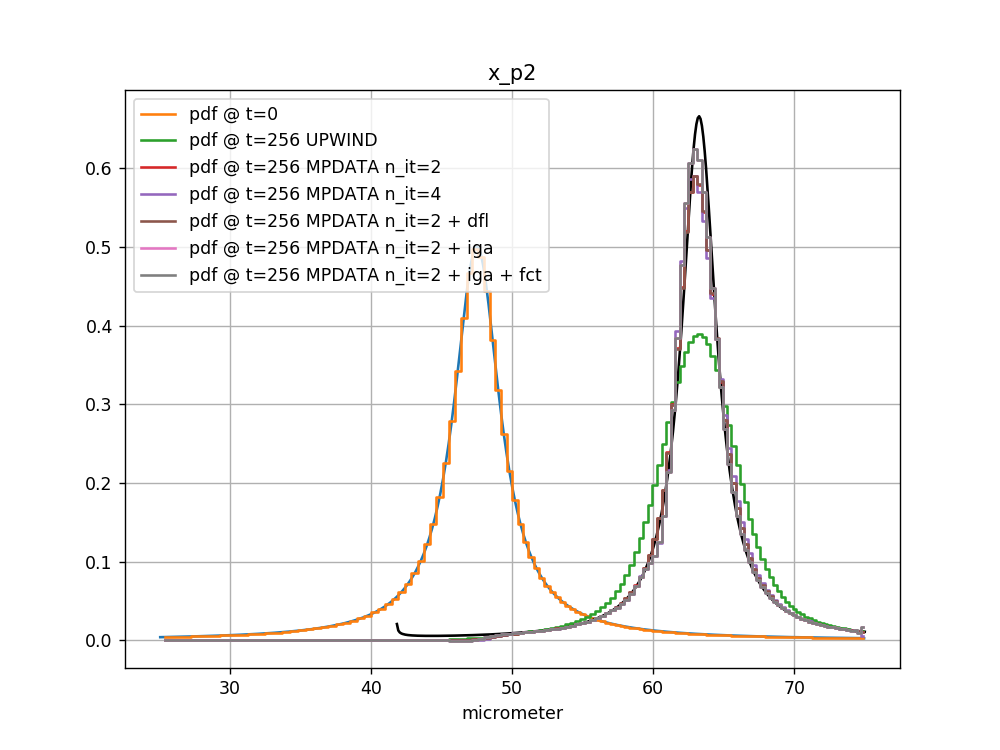

<IPython.core.display.Javascript object>


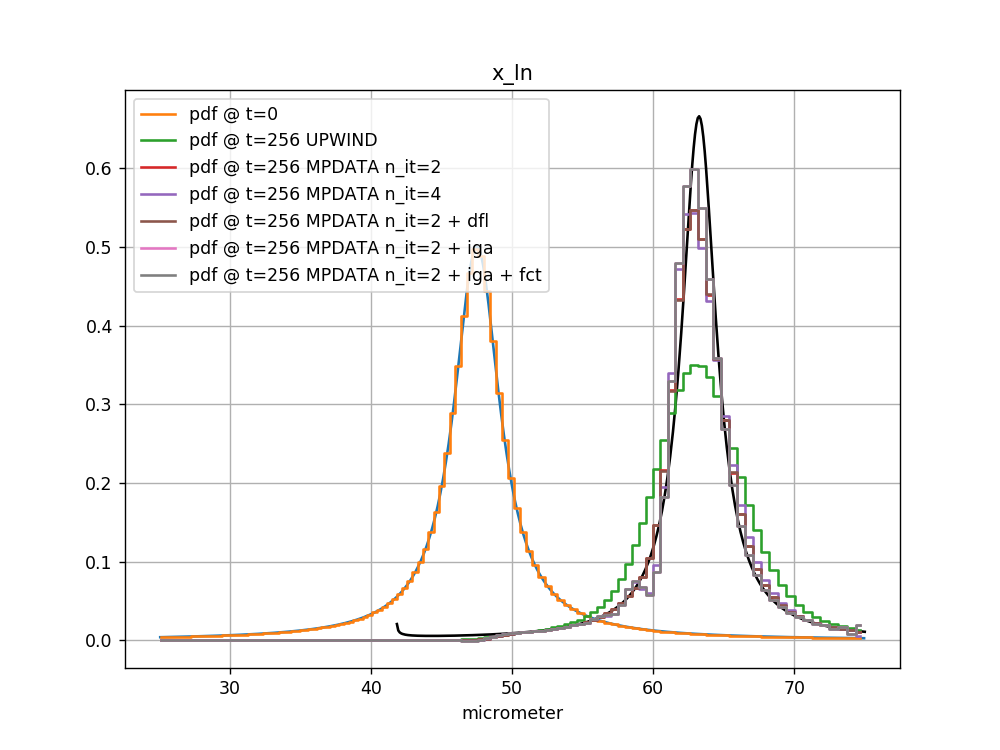

In [407]:
for fn in (x_id, x_p2, x_ln): 
    plot = plotter(r_min, r_max)
    
    algos = (
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"UPWIND",              "n_it":1}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2",       "n_it":2, "dfl":0, "iga":0, "fct":0}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=4",       "n_it":4, "dfl":0, "iga":0, "fct":0}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2 + dfl", "n_it":2, "dfl":1, "iga":0, "fct":0}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2 + iga", "n_it":2, "dfl":0, "iga":1, "fct":0}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2 + iga + fct", "n_it":2, "dfl":0, "iga":1, "fct":1}),
        #MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2 + iga + dfl", "n_it":2, "dfl":1, "iga":1}),
    )

    plot.pdf_cdf(cdf0)
    plot.step(algos[0].r, algos[0].pdf, "pdf @ t=0")

    for algo in algos:
        for t in range(nt): 
            algo.step(drdt)

    plot.pdf_pdf(Rogers)
    for algo in algos:
        plot.step(algo.r, algo.pdf, "pdf @ t=" + str(nt) + " " + algo.opts["label"])

    plot.done(fn.__name__)